## Importing packages

Here, we import a number of packages we will need to train our first model.

In [1]:
!pip install pvlib

In [2]:
import os
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
from ocf_blosc2 import Blosc2
from torch.utils.data import DataLoader, IterableDataset
from torchinfo import summary
import json
import geopandas as gpd
import seaborn as sns
from scipy.ndimage import zoom
import numpy as np
import h5py
import pvlib 
import math
import torch.nn.functional as F

plt.rcParams["figure.figsize"] = (20, 12)

Run this block to install all data

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device
if not os.path.exists("submission"):
     os.makedirs("submission", exist_ok=True)
     #Installing locally means you do not need to rerun this each time you restart the notebook
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/competition.py --output submission/competition.py
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/doxa.yaml --output submission/doxa.yaml
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/model.py --output submission/model.py
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/run.py --output submission/run.py
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/indices.json --output indices.json
if not os.path.exists("data"):
    os.makedirs("data/pv/2020", exist_ok=True)
    os.makedirs("data/satellite-hrv/2020", exist_ok=True)

    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/metadata.csv --output data/pv/metadata.csv
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/2020/7.parquet --output data/pv/2020/7.parquet
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/satellite-hrv/2020/7.zarr.zip --output data/satellite-hrv/2020/7.zarr.zip
pv = pd.read_parquet("data/pv/2020/7.parquet").drop("generation_wh", axis=1)
pv.index = pv.index.set_levels([pv.index.levels[0].tz_localize(None), pv.index.levels[1]])

#The parquet data here is similar to a dataframe. The "power" is the column with the other data types being indexes. The data is shaped with each timestamp being its own sub frame with the sites having their corresponding power (I think this is the % of their total possible yield).  
hrv = xr.open_dataset(
    "data/satellite-hrv/2020/7.zarr.zip", engine="zarr", chunks="auto"
)
#The way that this works is that it stores the image as a vector. The vectors are stored as an array of vectors. These then have a timestamp, as we only have one channel the array is a 1D set of vectors with the dimension being time. Read this to help you understand how this is being stored https://tutorial.xarray.dev/fundamentals/01_datastructures.html
# To access I have included some examples below
#The float value (float16-float64) shows the precision with which data is stored. Later on it is important to make sure that when you are feeding in data into the model that the float type matches between data types, this currently is not a problem when only using the HRV data. I am not yet sure if this will be a problem when using the NWP data.
with open("indices.json") as f:
    site_locations = {
        data_source: {
            int(site): (int(location[0]), int(location[1]))
            for site, location in locations.items() #if site == '2607'#added this to run only 1 site location to understand how it works
        }
        for data_source, locations in json.load(f).items()
    }
if not os.path.exists("data"):
    os.makedirs("data/pv/2020", exist_ok=True)
    os.makedirs("data/satellite-hrv/2020", exist_ok=True)

    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/metadata.csv --output data/pv/metadata.csv
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/2020/7.parquet --output data/pv/2020/7.parquet
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/satellite-hrv/2020/7.zarr.zip --output data/satellite-hrv/2020/7.zarr.zip 

In [76]:
print(site_locations)

{'hrv': {2607: (481, 224), 2626: (343, 345), 2631: (322, 187), 2657: (497, 174), 2660: (579, 214), 2729: (461, 180), 2760: (355, 414), 2766: (265, 380), 2770: (369, 219), 2775: (192, 108), 2776: (422, 255), 2784: (488, 220), 2789: (364, 401), 2813: (402, 237), 2814: (465, 208), 2815: (482, 236), 2816: (390, 230), 2822: (339, 203), 2824: (335, 131), 2828: (479, 223), 2832: (380, 191), 2833: (154, 109), 2834: (420, 245), 2835: (420, 228), 2855: (314, 375), 2880: (233, 365), 2881: (439, 202), 2903: (426, 196), 2908: (205, 99), 2912: (486, 137), 2918: (464, 199), 2940: (462, 200), 2975: (347, 164), 2997: (330, 291), 2998: (413, 174), 3000: (435, 444), 3001: (321, 231), 3005: (382, 276), 3007: (294, 372), 3016: (315, 371), 3019: (437, 201), 3026: (145, 106), 3039: (311, 323), 3074: (107, 86), 3080: (475, 218), 3085: (469, 199), 3089: (339, 455), 3093: (129, 97), 3094: (320, 378), 3100: (367, 401), 3117: (598, 233), 3122: (271, 368), 3126: (308, 381), 3146: (322, 375), 3147: (468, 154), 3149

## For generating the angle of solar incidence, you need to run up to the normalisation step to get the correct angle


In [56]:
#this block finds the long and lat for the sites where it is available 
pv_ss_id = pv.index.get_level_values("ss_id").unique()
pv_ss_time = pv.index.get_level_values("timestamp")
pv_meta = pd.read_csv("data/pv/metadata.csv")
pv_meta_ssid = pv_meta.ss_id
shared_id = [x for x in pv_ss_id if x in pv_meta_ssid]
pv_shared = pv_meta[pv_meta["ss_id"].isin(shared_id)] #shared location data, only 698 of 908 sites in the pv file have long and lat for plotting

#Merges 
pv_shared_merge = pv_shared[["ss_id", "latitude_rounded", "longitude_rounded", "orientation", "tilt"]]
pv_reset = pv.reset_index()

pv_az = pd.merge(pv_reset, pv_shared_merge[['ss_id', 'latitude_rounded', 'longitude_rounded', "orientation", "tilt"]], on='ss_id', how='left').dropna().set_index(["timestamp", "ss_id"])
pv_az_pre = pv_az.reset_index()

#Calculates the azimuth
location_data = {
    'latitude': pv_az_pre['latitude_rounded'],  # extract all sites latitude and longitude into Loc data
    'longitude': pv_az_pre['longitude_rounded'],
}
print(location_data)
# Ensure UTC timezone for PVlib to work
pv_az_pre['timestamp'] = pd.to_datetime(pv_az_pre['timestamp'], utc=True)#.dt.tz_convert(tz)
location = pvlib.location.Location(location_data['latitude'], location_data['longitude']) #tz default UTC, altitude default =0
solar_position = location.get_solarposition(pv_az_pre['timestamp']) #Based on location and time to calculate Solar Position
print(solar_position)
# Assign the azimuth values directly
pv_az_pre['solar_azimuth'] = solar_position['azimuth'].values
pv_az_pre['solar_zenith'] = solar_position['zenith'].values
print(pv_az_pre.describe())

########### Converting to radians for calculating the Solar Incidental angle ##############
pv_az_pre['solar_azimuth_radians'] = np.radians(pv_az_pre['solar_azimuth'])
pv_az_pre['solar_zenith_radians'] = np.radians(pv_az_pre['solar_zenith'])
pv_az_pre["panel_tilt_radians"] = np.radians(pv_az_pre['tilt'])
pv_az_pre["panel_orientation_radians"] = np.radians(pv_az_pre['orientation'])

print(pv_az_pre)

cos_theta_inc = (
    np.cos(pv_az_pre['solar_zenith_radians']) * np.cos(pv_az_pre['panel_tilt_radians']))+(np.sin(pv_az_pre['solar_zenith_radians']) * np.sin(pv_az_pre['panel_tilt_radians']) * np.cos((pv_az_pre['solar_azimuth_radians']-pv_az_pre["panel_orientation_radians"])))
pv_az_pre['angle_of_incidence_radians'] = np.arccos(cos_theta_inc)

{'latitude': 0          52.44
1          54.99
2          51.81
3          51.49
4          51.61
           ...  
6039341    53.59
6039342    53.55
6039343    53.76
6039344    53.10
6039345    53.06
Name: latitude_rounded, Length: 6039346, dtype: float64, 'longitude': 0         -0.12
1         -3.18
2         -2.50
3          0.36
4         -0.24
           ... 
6039341   -3.04
6039342   -2.23
6039343   -1.52
6039344   -2.04
6039345   -2.98
Name: longitude_rounded, Length: 6039346, dtype: float64}
                           apparent_zenith      zenith  apparent_elevation  \
timestamp                                                                    
2020-07-01 00:00:00+00:00       104.469109  104.469109          -14.469109   
2020-07-01 00:00:00+00:00       101.844074  101.844074          -11.844074   
2020-07-01 00:00:00+00:00       105.043198  105.043198          -15.043198   
2020-07-01 00:00:00+00:00       105.423181  105.423181          -15.423181   
2020-07-01 00:00:00+00:00   

In [57]:
pv_inc = pv_az_pre.drop(columns={'latitude_rounded', 'longitude_rounded',
       'orientation', 'tilt', 'solar_azimuth',
       'solar_azimuth_radians', 'solar_zenith', 'solar_zenith_radians',
       'panel_tilt_radians',
       'panel_orientation_radians'}).sort_values([ "timestamp"]).set_index(["timestamp", "ss_id"])

In [58]:
pv_inc_chk = pv_inc.reset_index()

Getting final outputs for the pv_inc and formatting them

In [59]:
df = pv_inc.reset_index()
df["timestamp"] = pd.to_datetime(df["timestamp"])
pv_inc = df.set_index(["timestamp", "ss_id"])

pv_inc.index = pv_inc.index.set_levels([pv_inc.index.levels[0].tz_localize(None), pv_inc.index.levels[1]])


Nomralising power and angle

In [60]:
pv_norm = pv_inc

power_min = pv_norm['power'].min()
power_range = pv_norm['power'].max() - power_min
pv_norm['power_normalized'] = (pv_norm['power'] - power_min) / power_range

# Normalize the 'angle_of_incidence_radians' column
angle_min = pv_norm['angle_of_incidence_radians'].min()
angle_range = pv_norm['angle_of_incidence_radians'].max() - angle_min
pv_norm['angle_of_incidence_radians_normalized'] = (pv_norm['angle_of_incidence_radians'] - angle_min) / angle_range

pv_inc =pv_norm

In [61]:
print(pv_inc.columns)


Index(['power', 'angle_of_incidence_radians', 'power_normalized',
       'angle_of_incidence_radians_normalized'],
      dtype='object')


In [62]:

#pv_inc = pv_inc.set_index(["timestamp", "ss_id"])
print(pv_inc)

                           power  angle_of_incidence_radians  \
timestamp           ss_id                                      
2020-07-01 00:00:00 2607     0.0                    2.378988   
                    7905     0.0                    1.363505   
                    7906     0.0                    2.206425   
                    7907     0.0                    2.275762   
                    7910     0.0                    2.273475   
...                          ...                         ...   
2020-07-31 23:55:00 6781     0.0                    2.296199   
                    6785     0.0                    2.450600   
                    6786     0.0                    2.370474   
                    6726     0.0                    2.194937   
                    23083    0.0                    2.167528   

                           power_normalized  \
timestamp           ss_id                     
2020-07-01 00:00:00 2607                0.0   
                    7905  

"For a deep learning model like a ResNet, standardization is commonly used because it generally makes training less sensitive to the scale of features and their values. Neural networks often perform better with standardized inputs, especially in the deeper layers."



In [138]:
#pv_inc.to_csv("pv_inc_2020_07.csv")

In [3]:
#pv_inc = pd.read_csv("pv_inc_2020_07.csv")
#pv_inc = pv_inc.set_index(["timestamp", "ss_id"])

6x6  hour

In [14]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset_crop6_60m(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv, hrv, site_locations, start_date = "2020-7-1", end_date = "2020-7-30", sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv = pv
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys
        self.start_date = list(map(int, start_date.split("-")))
        self.end_date= list(map(int, end_date.split("-")))

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(self.start_date[0], self.start_date[1], self.start_date[2])
        max_date = datetime(self.end_date[0], self.end_date[1], self.end_date[2])
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            time_ids = pd.date_range(start=time + timedelta(hours=1),
                                     end=time + timedelta(hours=1)+timedelta(minutes=55),
                                     freq='5min')
            time_ids = time_ids.strftime('%Y-%m-%dT%H:%M:%S').tolist()        
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  

            pv_features = pv.xs(first_hour, drop_level=False)  # this gets the pv yield of the current timestamp selected earlier
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=1, minutes=55)),
                ),
                drop_level=False,
            )#pv targets defines the time span over which we are trying to make pv yield predictions
            #print( pv_features)
            #print(pv_features)

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()#gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature

            for site in self._sites:
                site_id = site
                try:
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    assert site_features.shape == (12,) and site_targets.shape == (12,)#compresses the data from N dimensions to 12 and 48 respectively
                    #print(site)
                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 3 : y + 3, x - 3 : x + 3, 0]
                    assert hrv_features.shape == (12, 6, 6)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield  time_ids, site_id, site_features, hrv_features, site_targets

In [15]:
dataset = ChallengeDataset_crop6_60m(pv, hrv, site_locations, "2020-7-1", "2020-7-30")

# Creating an iterator from the dataset
dataset_iterator = iter(dataset)

# Number of samples to print
num_samples_to_print = 1  # You can adjust this number based on how many samples you want to check

# Iterate through the dataset and print pv_targets
for i in range(num_samples_to_print):
    try:
        time_ids, site_id, pv_features, hrv_features, pv_targets = next(dataset_iterator)
        print(f"Site ID: {site_id}, PV Targets: {len(hrv_features)}")
    except StopIteration:
        print("No more data available in the dataset.")
        break
    except Exception as e:
        print(f"An error occurred: {e}")
        continue

Site ID: 2607, PV Targets: 12


3 x 3 hour

In [16]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset_crop3_360m(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv, hrv, site_locations, start_date = "2020-7-1", end_date = "2020-7-30", sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv = pv
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys
        self.start_date = list(map(int, start_date.split("-")))
        self.end_date= list(map(int, end_date.split("-")))

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(self.start_date[0], self.start_date[1], self.start_date[2])
        max_date = datetime(self.end_date[0], self.end_date[1], self.end_date[2])
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            time_ids = pd.date_range(start=time + timedelta(hours=1),
                                     end=time + timedelta(hours=1)+timedelta(minutes=55),
                                     freq='5min')
            time_ids = time_ids.strftime('%Y-%m-%dT%H:%M:%S').tolist()        
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  

            pv_features = pv.xs(first_hour, drop_level=False)  # this gets the pv yield of the current timestamp selected earlier
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=1, minutes=55)),
                ),
                drop_level=False,
            )#pv targets defines the time span over which we are trying to make pv yield predictions
            #print( pv_features)
            #print(pv_features)

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()#gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature

            for site in self._sites:
                site_id = site
                try:
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    assert site_features.shape == (12,) and site_targets.shape == (12,)#compresses the data from N dimensions to 12 and 48 respectively
                    #print(site)
                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 3 : y + 3, x - 3 : x + 3, 0]
                    assert hrv_features.shape == (12, 6, 6)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield  time_ids, site_id, site_features, hrv_features, site_targets

1x1 hour

In [17]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset_crop1_60m(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv, hrv, site_locations, start_date = "2020-7-1", end_date = "2020-7-30", sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv = pv
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys
        self.start_date = list(map(int, start_date.split("-")))
        self.end_date= list(map(int, end_date.split("-")))

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(self.start_date[0], self.start_date[1], self.start_date[2])
        max_date = datetime(self.end_date[0], self.end_date[1], self.end_date[2])
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            time_ids = pd.date_range(start=time + timedelta(hours=1),
                                     end=time + timedelta(hours=1)+timedelta(minutes=55),
                                     freq='5min')
            time_ids = time_ids.strftime('%Y-%m-%dT%H:%M:%S').tolist()        
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  

            pv_features = pv.xs(first_hour, drop_level=False)  # this gets the pv yield of the current timestamp selected earlier
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=1, minutes=55)),
                ),
                drop_level=False,
            )#pv targets defines the time span over which we are trying to make pv yield predictions
            #print( pv_features)
            #print(pv_features)

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()#gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature

            for site in self._sites:
                site_id = site
                try:
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    assert site_features.shape == (12,) and site_targets.shape == (12,)#compresses the data from N dimensions to 12 and 48 respectively
                    #print(site)
                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y  : y + 1, x  : x + 1, 0]
                    assert hrv_features.shape == (12, 1, 1)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield  time_ids, site_id, site_features, hrv_features, site_targets

To change crop sizes you need to change the elements below

In [18]:
#hrv_features = hrv_data[:, y - 3 : y + 3, x - 3 : x + 3, 0]
                  #  assert hrv_features.shape == (12, 6, 6)#crops the image to be be 128x128 around the site

In [19]:
#hrv_features = hrv_data[:, y  : y + 1, x  : x + 1, 0]
                 #   assert hrv_features.shape == (12, 1, 1)#crops the image to be be 128x128 around the site

In [20]:
#hrv_features = hrv_data[:, y - 3 : y + 3, x - 3 : x + 3, 0]
                    #assert hrv_features.shape == (12, 6, 6)#crops the image to be be 128x128 around the site

Solar inci loader 6 x 6 four hour

Solar angle data loader

In [21]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset_inc(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv_inc, hrv, site_locations, start_date = "2020-7-1", end_date = "2020-7-30", sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv_inc = pv_inc
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys
        self.start_date = list(map(int, start_date.split("-")))
        self.end_date= list(map(int, end_date.split("-")))

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(self.start_date[0], self.start_date[1], self.start_date[2])
        max_date = datetime(self.end_date[0], self.end_date[1], self.end_date[2])
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            time_ids = pd.date_range(start=time + timedelta(hours=1),
                                     end=time + timedelta(hours=5) - timedelta(minutes=5),
                                     freq='5min')
            time_ids = time_ids.strftime('%Y-%m-%dT%H:%M:%S').tolist()    
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  
            #print("Available columns in pv_inc:", self.pv_inc.columns)
           
            pv_features = self.pv_inc.xs(first_hour, drop_level=False)[["power", "angle_of_incidence_radians"]]

        # Fetching PV targets for the future time span
            pv_targets = self.pv_inc.xs(
                slice(
                    str(time + timedelta(hours=1)),  # Start 1 hour after the first_hour
                    str(time + timedelta(hours=4, minutes=55)),  # Up to almost 5 hours later
                ),
                drop_level=False,
            )["power"]
            #print("First hour slice:", first_hour)
            #print("Sample data from pv_inc:", self.pv_inc.xs(first_hour, drop_level=False).head())
            #gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature
            hrv_data = self.hrv['data'].sel(time=first_hour).to_numpy()

            for site in self._sites:
                site_id = site

                try:
                    #print(site)
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy()#.squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    
                    site_targets = pv_targets.xs(site, level=1).to_numpy()#.squeeze(-1)
                    assert site_features.shape == (12,2) and site_targets.shape == (48,)#compresses the data from N dimensions to 12 and 48 respectively
                  
                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 3 : y + 3, x - 3 : x + 3, 0]
                    assert hrv_features.shape == (12, 6, 6)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield  time_ids, site_id, site_features, hrv_features, site_targets

6 x 6 solar inc one hour

In [22]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset_inc_60m(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv_inc, hrv, site_locations, start_date = "2020-7-1", end_date = "2020-7-30", sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv_inc = pv_inc
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys
        self.start_date = list(map(int, start_date.split("-")))
        self.end_date= list(map(int, end_date.split("-")))

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(self.start_date[0], self.start_date[1], self.start_date[2])
        max_date = datetime(self.end_date[0], self.end_date[1], self.end_date[2])
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            time_ids = pd.date_range(start=time + timedelta(hours=1),
                                     end=time + timedelta(hours=5) - timedelta(minutes=5),
                                     freq='5min')
            time_ids = time_ids.strftime('%Y-%m-%dT%H:%M:%S').tolist()    
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  
            #print("Available columns in pv_inc:", self.pv_inc.columns)
           
            pv_features = self.pv_inc.xs(first_hour, drop_level=False)[["power", "angle_of_incidence_radians"]]

        # Fetching PV targets for the future time span
            pv_targets = self.pv_inc.xs(
                slice(
                    str(time + timedelta(hours=1)),  # Start 1 hour after the first_hour
                    str(time + timedelta(hours=4, minutes=55)),  # Up to almost 5 hours later
                ),
                drop_level=False,
            )["power"]
            #print("First hour slice:", first_hour)
            #print("Sample data from pv_inc:", self.pv_inc.xs(first_hour, drop_level=False).head())
            #gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature
            hrv_data = self.hrv['data'].sel(time=first_hour).to_numpy()

            for site in self._sites:
                site_id = site

                try:
                    #print(site)
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy()#.squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    
                    site_targets = pv_targets.xs(site, level=1).to_numpy()#.squeeze(-1)
                    assert site_features.shape == (12,2) and site_targets.shape == (12,)#compresses the data from N dimensions to 12 and 48 respectively
                  
                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 3 : y + 3, x - 3 : x + 3, 0]
                    assert hrv_features.shape == (12, 6, 6)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield  time_ids, site_id, site_features, hrv_features, site_targets

Solar angle model four hours

In [23]:
layers = [4, 4, 4, 4] #Change this to change the number of layers that you are using, 

def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    #This section creates a sequence of layers that perform the networks convolution which are applied iteratively in the Resnet_light block
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding), #Feature extraction
        nn.BatchNorm2d(out_channels), #Noramlises the outputs from the convolution layers
        nn.ReLU(inplace=True)#Applies the activation function
    )

class BasicBlock(nn.Module):
    expansion = 1 
    #Applies the convolution established in the previous layer twice giving the F(x) portion of the resnet model
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x): #Keeps the x portion of the resnet 
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None: #Downsamples the model if needed to match the dimensions of outputs if the identity output does not match the F(x) portion of the output
            identity = self.downsample(x)
        out = out + identity #Creates the F(x) + x that is then passed to the relu activation function between the resnet conv layers
        return F.relu(out, inplace=False)  #Relu applied to combined results, 

class ResNet_light_inc(nn.Module):
    #This class stacks the multiple basic blocks set up in the previous functions
    def __init__(self, block, layers):
        #I Think we can reduce the number of layers here as the model is applied four convolutions to generate F(x), the resnet paper uses two.
        super(ResNet_light_inc, self).__init__()
        self.in_channels = 12 #reduce the stride
        self.initial = conv_block(12, 12, kernel_size=2, stride=1, padding=3)#Applies the initial convolution 
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)#Runs maxpool convolution
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))#Forces the consistency of output sizes to be 1x1 
        # Adjust this linear layer based on the concatenated size of HRV and PV features
        self.fc = nn.Linear(96  + 12, 48)  #takes the flatterened output of the conv layers for the 12 hourly time instances and then hands them to 48 different class outputs

    def _make_layer(self, block, out_channels, num_blocks, stride=1):#Used to stack the multiple layers of the resnet model
        downsample = None#This checks to make sure that the stride applied matches between input tensor and the output tensor, I am not completely sure if this changes the dimensions of the output tensor
        if stride != 1 or self.in_channels != out_channels * block.expansion:#Expands the number of outputs compared to the inputs, for the BasicBlock typically no expansion is needed. This is still needed for the model to run. 
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]#This section creates a series of blocks for the layer
        self.in_channels = out_channels * block.expansion #Ensures that after the blocks have been defined the next layer gets the correct number of input channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))#
        return nn.Sequential(*layers)#Stretches the dims of the resnet to match the layers defined above
        #Need to clarify exactly what expansion is doing.
    def forward(self, pv_inc, hrv ):#Defines how the model passes the outputs through the network
        #print("Initial HRV shape:", hrv.shape)  
        #print("Initial PV shape:", pv.shape) 
        #print(f"{pv[0]}")
        x = self.initial(hrv)#Passes the HRV data through the initial block defined earlier
        x = self.maxpool(x)#Downsamples using maxpooling
        #print("Shape after initial conv and maxpool:", x.shape)

        x = self.layer1(x)#Applies the layers defined above, 
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print("Shape after ResNet_light blocks:", x.shape)

        x = self.avgpool(x)
        #print("Shape after avgpool:", x.shape)
        x = torch.flatten(x, 1)# Applies the flattering to the second dimension as the first dimension is the batch size
        pv_inc = torch.flatten(pv_inc, start_dim=1)#take in at the fully connected layer
        #print(f"Sshape of x = {x.shape} shape of pv = {pv.shape}")
        #x = torch.concat((x, pv), dim=-1)
        #print("Shape after avgpool and flatten:", x.shape)

        #Take in the pc_inc and the pv power as seperate features and run the model again
        
        #pv = pv.view(pv.size(0), -1)
        #Checks to make sure that the pv tensor dimensions match the HRV tensor dimensions
        if pv_inc.dim() > 2:
            pv_inc = torch.flatten(pv_inc, start_dim=1)
        #print("Adjusted PV shape:", pv.shape)

        combined = torch.cat((x, pv_inc), dim=1)#Combines the pv and hrv data along the feature dimension

        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 48).to(combined.device)
            #Above runs a check to make sure that the number of input features is correct
        out = self.fc(combined) #takes the combined output of the pv and hrv and passes them to the fully connected layer defined above
        return out
model_light_res_inc = ResNet_light_inc(BasicBlock, layers).to(device)


Solar angle model 1 hour

In [24]:
layers = [4, 4, 4, 4] #Change this to change the number of layers that you are using, 

def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    #This section creates a sequence of layers that perform the networks convolution which are applied iteratively in the Resnet_light block
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding), #Feature extraction
        nn.BatchNorm2d(out_channels), #Noramlises the outputs from the convolution layers
        nn.ReLU(inplace=True)#Applies the activation function
    )

class BasicBlock(nn.Module):
    expansion = 1 
    #Applies the convolution established in the previous layer twice giving the F(x) portion of the resnet model
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x): #Keeps the x portion of the resnet 
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None: #Downsamples the model if needed to match the dimensions of outputs if the identity output does not match the F(x) portion of the output
            identity = self.downsample(x)
        out = out + identity #Creates the F(x) + x that is then passed to the relu activation function between the resnet conv layers
        return F.relu(out, inplace=False)  #Relu applied to combined results, 

class ResNet_light_inc_60m(nn.Module):
    #This class stacks the multiple basic blocks set up in the previous functions
    def __init__(self, block, layers):
        #I Think we can reduce the number of layers here as the model is applied four convolutions to generate F(x), the resnet paper uses two.
        super(ResNet_light_inc_60m, self).__init__()
        self.in_channels = 12 #reduce the stride
        self.initial = conv_block(12, 12, kernel_size=2, stride=1, padding=3)#Applies the initial convolution 
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)#Runs maxpool convolution
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))#Forces the consistency of output sizes to be 1x1 
        # Adjust this linear layer based on the concatenated size of HRV and PV features
        self.fc = nn.Linear(96  + 12, 12)  #takes the flatterened output of the conv layers for the 12 hourly time instances and then hands them to 48 different class outputs

    def _make_layer(self, block, out_channels, num_blocks, stride=1):#Used to stack the multiple layers of the resnet model
        downsample = None#This checks to make sure that the stride applied matches between input tensor and the output tensor, I am not completely sure if this changes the dimensions of the output tensor
        if stride != 1 or self.in_channels != out_channels * block.expansion:#Expands the number of outputs compared to the inputs, for the BasicBlock typically no expansion is needed. This is still needed for the model to run. 
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]#This section creates a series of blocks for the layer
        self.in_channels = out_channels * block.expansion #Ensures that after the blocks have been defined the next layer gets the correct number of input channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))#
        return nn.Sequential(*layers)#Stretches the dims of the resnet to match the layers defined above
        #Need to clarify exactly what expansion is doing.
    def forward(self, pv_inc, hrv ):#Defines how the model passes the outputs through the network
        #print("Initial HRV shape:", hrv.shape)  
        #print("Initial PV shape:", pv.shape) 
        #print(f"{pv[0]}")
        x = self.initial(hrv)#Passes the HRV data through the initial block defined earlier
        x = self.maxpool(x)#Downsamples using maxpooling
        #print("Shape after initial conv and maxpool:", x.shape)

        x = self.layer1(x)#Applies the layers defined above, 
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print("Shape after ResNet_light blocks:", x.shape)

        x = self.avgpool(x)
        #print("Shape after avgpool:", x.shape)
        x = torch.flatten(x, 1)# Applies the flattering to the second dimension as the first dimension is the batch size
        pv_inc = torch.flatten(pv_inc, start_dim=1)#take in at the fully connected layer
        #print(f"Sshape of x = {x.shape} shape of pv = {pv.shape}")
        #x = torch.concat((x, pv), dim=-1)
        #print("Shape after avgpool and flatten:", x.shape)

        #Take in the pc_inc and the pv power as seperate features and run the model again
        
        #pv = pv.view(pv.size(0), -1)
        #Checks to make sure that the pv tensor dimensions match the HRV tensor dimensions
        if pv_inc.dim() > 2:
            pv_inc = torch.flatten(pv_inc, start_dim=1)
        #print("Adjusted PV shape:", pv.shape)

        combined = torch.cat((x, pv_inc), dim=1)#Combines the pv and hrv data along the feature dimension

        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 12).to(combined.device)
            #Above runs a check to make sure that the number of input features is correct
        out = self.fc(combined) #takes the combined output of the pv and hrv and passes them to the fully connected layer defined above
        return out
model_light_res_inc_60m = ResNet_light_inc_60m(BasicBlock, layers).to(device)


1 x 1, 3 x 3, 6 x 6 four hours resnet

In [25]:
layers = [4, 4, 4, 4] #For a deeper resnet with 16 total conv layers

def conv_block(in_channels, out_channels, kernel_size=1, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        return F.relu(out, inplace=False)

class ResNet_light_deep_crop1(nn.Module):
    
    def __init__(self, block, layers):
        
        super(ResNet_light_deep_crop1, self).__init__()
        self.in_channels = 12 #reduce the stride
        self.initial = nn.Identity()
        #self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=1)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
        # Adjust this linear layer based on the concatenated size of HRV and PV features
        self.fc = nn.Linear(96  + 12, 48)  

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, pv, hrv ):
        #print("Initial HRV shape:", hrv.shape)  
        #print("Initial PV shape:", pv.shape) 
        #print(f"{pv[0]}")
        x = self.initial(hrv)
        #x = self.maxpool(x)
        #print("Shape after initial conv and maxpool:", x.shape)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print("Shape after ResNet_light blocks:", x.shape)

        x = self.avgpool(x)
        #print("Shape after avgpool:", x.shape)
        x = torch.flatten(x, 1)
        pv = torch.flatten(pv, start_dim=1)
        #print(f"Sshape of x = {x.shape} shape of pv = {pv.shape}")
        #x = torch.concat((x, pv), dim=-1)
        #print("Shape after avgpool and flatten:", x.shape)

        
        
        #pv = pv.view(pv.size(0), -1)
        if pv.dim() > 2:
            pv = torch.flatten(pv, start_dim=1)
        #print("Adjusted PV shape:", pv.shape)

        combined = torch.cat((x, pv), dim=1)

        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 48).to(combined.device)

        out = self.fc(combined)
        return out
model_light_deep_res_crop1 = ResNet_light_deep_crop1(BasicBlock, layers).to(device)


1 x 1, 3 x 3, 6 x 6 one hour resnet

In [26]:
layers = [4, 4, 4, 4] #For a deeper resnet with 16 total conv layers

def conv_block(in_channels, out_channels, kernel_size=1, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        return F.relu(out, inplace=False)

class ResNet_light_deep_crop1_60m(nn.Module):
    
    def __init__(self, block, layers):
        
        super(ResNet_light_deep_crop1_60m, self).__init__()
        self.in_channels = 12 #reduce the stride
        self.initial = nn.Identity()
        #self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=1)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
        # Adjust this linear layer based on the concatenated size of HRV and PV features
        self.fc = nn.Linear(96  + 12, 12)  

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, pv, hrv ):
        #print("Initial HRV shape:", hrv.shape)  
        #print("Initial PV shape:", pv.shape) 
        #print(f"{pv[0]}")
        x = self.initial(hrv)
        #x = self.maxpool(x)
        #print("Shape after initial conv and maxpool:", x.shape)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print("Shape after ResNet_light blocks:", x.shape)

        x = self.avgpool(x)
        #print("Shape after avgpool:", x.shape)
        x = torch.flatten(x, 1)
        pv = torch.flatten(pv, start_dim=1)
        #print(f"Sshape of x = {x.shape} shape of pv = {pv.shape}")
        #x = torch.concat((x, pv), dim=-1)
        #print("Shape after avgpool and flatten:", x.shape)

        
        
        #pv = pv.view(pv.size(0), -1)
        if pv.dim() > 2:
            pv = torch.flatten(pv, start_dim=1)
        #print("Adjusted PV shape:", pv.shape)

        combined = torch.cat((x, pv), dim=1)

        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 12).to(combined.device)

        out = self.fc(combined)
        return out
model_light_deep_res_crop1_60m = ResNet_light_deep_crop1_60m(BasicBlock, layers).to(device)


16 x 16 one hour under development, parameters need tuning

In [27]:
layers = [4, 4, 4, 4] #For a deeper resnet with 16 total conv layers

def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        return F.relu(out, inplace=False)

class ResNet_light_deep_crop16_60m(nn.Module):
    
    def __init__(self, block, layers):
        
        super(ResNet_light_deep_crop16_60m, self).__init__()
        self.in_channels = 12 #reduce the stride
        self.initial = nn.Identity()
        #self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=1)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
        # Adjust this linear layer based on the concatenated size of HRV and PV features
        self.fc = nn.Linear(96  + 12, 12)  

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, pv, hrv ):
        #print("Initial HRV shape:", hrv.shape)  
        #print("Initial PV shape:", pv.shape) 
        #print(f"{pv[0]}")
        x = self.initial(hrv)
        #x = self.maxpool(x)
        #print("Shape after initial conv and maxpool:", x.shape)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print("Shape after ResNet_light blocks:", x.shape)

        x = self.avgpool(x)
        #print("Shape after avgpool:", x.shape)
        x = torch.flatten(x, 1)
        pv = torch.flatten(pv, start_dim=1)
        #print(f"Sshape of x = {x.shape} shape of pv = {pv.shape}")
        #x = torch.concat((x, pv), dim=-1)
        #print("Shape after avgpool and flatten:", x.shape)

        
        
        #pv = pv.view(pv.size(0), -1)
        if pv.dim() > 2:
            pv = torch.flatten(pv, start_dim=1)
        #print("Adjusted PV shape:", pv.shape)

        combined = torch.cat((x, pv), dim=1)

        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 12).to(combined.device)

        out = self.fc(combined)
        return out
model_light_deep_res_crop16_60m = ResNet_light_deep_crop16_60m(BasicBlock, layers).to(device)


model_light_deep_res_crop1 = ResNet_light_deep_crop1(BasicBlock, layers)
print(model_light_deep_res_crop1)

## Training models
This generates weights for the model that we can then use for validation. The weights are then saved as the model submission meaning that each time we generate weights we can then save the weights along with the associated model.

Incidence check
One hour for small CNN
Criterion measures (faster convergence, faster training)
1x1, 6x6, 128
1 hour incidence, set up for Ovais



RMSE criterion and validation functions


In [28]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, predicted, actual):
        return torch.sqrt(self.mse(predicted, actual))

criterion = RMSELoss()

def model_validation(model, criterion, validation_dataloader):
    model.eval() # This is used to set the model to evaluation mode
    with torch.no_grad(): # This is used to stop the model from storing gradients
        losses = []
        for pv_features, hrv_features, pv_targets in validation_dataloader:
            pv_features, hrv_features, pv_targets = pv_features.to(device, dtype=torch.float), hrv_features.to(device, dtype=torch.float), pv_targets.to(device, dtype=torch.float)
            predictions = model(pv_features, hrv_features)
            loss = criterion(predictions, pv_targets)
            losses.append(loss.item())

    model.train() # This is used to set the model back to training mode
    
    return sum(losses) / len(losses)

def model_validation_indv(model, criterion, validation_dataloader):
    model.eval()  # Set the model to evaluation mode
    individual_losses = []  # List to store each individual loss

    with torch.no_grad():  # Disable gradient computation
        for pv_features, hrv_features, pv_targets in validation_dataloader:
            pv_features, hrv_features, pv_targets = pv_features.to(device, dtype=torch.float), hrv_features.to(device, dtype=torch.float), pv_targets.to(device, dtype=torch.float)

            predictions = model(pv_features, hrv_features)  # Get model predictions
            
            # Calculate loss for each individual in the batch
            individual_batch_losses = criterion(predictions, pv_targets, reduction='none')  # This should return a tensor of losses for each item in the batch
            
            individual_losses.extend(individual_batch_losses.tolist())  # Convert tensor to list and append to the list of losses
            
    model.train()  # Set the model back to training mode
    return individual_losses

1 x 1 training for one hour change the dataloader and the model loaded as needed

In [77]:
#1 x 1 
BATCH_SIZE = 32#This controls the number of sites that predictions are made for I think
#6x6 for 4 hours prediction: #ChallengeDataset_inc #model_light_deep_res_crop1 model_light_res_inc
#the number of sites per batch

#load the data based on the previously defined functions above, the above functions can be altered to change how the data is ingested
train_dataset = ChallengeDataset_inc(pv_inc, hrv, site_locations=site_locations,
                                 start_date="2020-7-1", end_date="2020-7-02")  # controls which data is loaded in
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)

validation_dataset = ChallengeDataset_inc(pv_inc, hrv, site_locations=site_locations,
                                      start_date="2020-7-31", end_date="2020-7-31") 
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, pin_memory=True)  # controls which data is loaded in
model = model_light_res_inc
criterion = RMSELoss()#nn.L1Loss()#Here we are defining the test stat as MAE
optimiser = optim.Adam(model.parameters(), lr=1e-3)

Training and validation loop. Includes unpacking for id and time to get the batch dataframe

In [78]:
EPOCHS = 1
training_losses = []
validation_losses = []
epoch_train_losses = []
epoch_validation_losses = []
timestamps = []
site_ids = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    count = 0

    # Training loop
    for i, (site_id, time_id, pv_features, hrv_features, pv_targets) in enumerate(train_dataloader):
        if epoch == 0:
            timestamps.append(time_id)
           

        site_ids.append(site_id)
        optimiser.zero_grad()
        pv_features, hrv_features, pv_targets = \
            pv_features.to(device, dtype=torch.float), \
            hrv_features.to(device, dtype=torch.float), \
            pv_targets.to(device, dtype=torch.float)

        predictions = model(pv_features, hrv_features)
        loss = criterion(predictions, pv_targets)
        loss.backward()
        #print(f"{loss}")
        optimiser.step()
        
        size = pv_targets.size(0)
        running_loss += float(loss) * size
        count += size
        #print(f"{count}")
        #print(f"{running_loss}")
        #print(f"{size}")
        if i % 200 == 199:
            current_loss = running_loss / count
            training_losses.append(current_loss)
            #print(f"training loss: {training_losses} current loss: {current_loss}")
            print(f"Epoch {epoch + 1}, Batch {i + 1}: Training Loss: {current_loss}")

            # Validation
            model.eval()
            validation_loss = 0
            val_count = 0
            for val_site, val_time, val_pv_features, val_hrv_features, val_pv_targets in validation_dataloader:
                val_pv_features, val_hrv_features, val_pv_targets = \
                    val_pv_features.to(device, dtype=torch.float), \
                    val_hrv_features.to(device, dtype=torch.float), \
                    val_pv_targets.to(device, dtype=torch.float)
                val_predictions = model(val_pv_features, val_hrv_features)
                val_loss = criterion(val_predictions, val_pv_targets)

                val_size = val_pv_targets.size(0)
                validation_loss += float(val_loss) * val_size
                val_count += val_size

            validation_loss /= val_count
            validation_losses.append(validation_loss)
            print(f"     Validation Loss: {validation_loss}\n")

    epoch_train_loss = running_loss / count
    epoch_train_losses.append(epoch_train_loss)  

    print(f"Epoch {epoch + 1} Completed: Training Loss: {epoch_train_loss}")

Epoch 1, Batch 200: Training Loss: 0.18238800451159476
     Validation Loss: 0.2688548506449934

Epoch 1 Completed: Training Loss: 0.1755998918314081


Epoch 1, 3800: 0.15208584108733034 for fourty layers deep resnet 1x1


Original training loop, no validation

In [71]:
EPOCHS = 10
batch_losses = []
val_losses = []
epoch_train_losses = []
epoch_val_losses = []
for epoch in range(EPOCHS):
    model.train()

    running_loss = 0.0##sets the starting loss at zero
    count = 0#is used to keep track of the number of batches passed through the training model
  
    for i, (pv_features, hrv_features, pv_targets) in enumerate(dataloader): 
        
        optimiser.zero_grad()#resets the gradient of all the previous weights and biases used in the model, can be changed to alter the type of optimiser we use
        predictions = model(
            pv_features.to(device, dtype=torch.float),
            hrv_features.to(device, dtype=torch.float),
        )#makes predictions based off of current batch of hrv and pv inputs
        loss = criterion(predictions, pv_targets.to(device, dtype=torch.float))#calculates the loss between the models predictions and the actual pv
        loss.backward()#backprops the loss

        optimiser.step()#updates the parameters based on the calculated loss
        ###for generating the training and test loss graph
        running_loss += loss.item() * pv_targets.size(0)
        count += pv_targets.size(0)
        optimiser.step()
        
        size = int(pv_targets.size(0))#calculates the size of the first dimension of the pv_targets tensor  to determine how many data points are in the current tensor
        running_loss += float(loss) * size
        count += size
        #print(count)
        #prints the current training loss for the first 200 data points of 32 batches, then prints again once the next 200 have been computed
        if i % 200 == 199:
            print(f"Epoch {epoch + 1}, {i + 1}: {running_loss / count}")
    epoch_train_loss = running_loss / count
    epoch_train_losses.append(epoch_train_loss)        
    print(f"Epoch {epoch + 1}: {running_loss / count}")
    
    

NameError: name 'dataloader' is not defined

/Users/Elzantohboonleong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Elzantohboonleong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Elzantohboonleong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Elzantohboonleong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

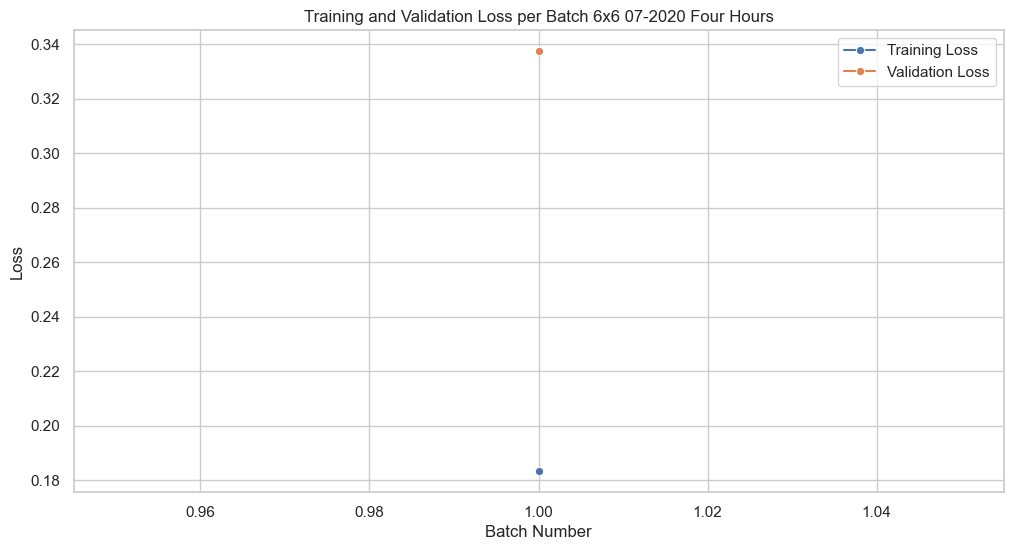

In [73]:
batch_indices = list(range(1, len(training_losses) + 1))

df_vis = pd.DataFrame({
    "Batch": batch_indices,
    "Training Loss": training_losses,
    "Validation Loss": validation_losses
})
sns.set(style="whitegrid")

# Create a new figure
plt.figure(figsize=(12, 6))

# Plot training and validation losses
sns.lineplot(data=df_vis, x="Batch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df_vis, x="Batch", y="Validation Loss", label="Validation Loss", marker='o')

# Add labels and title
plt.title('Training and Validation Loss per Batch 6x6 07-2020 Four Hours')
plt.xlabel('Batch Number')
plt.ylabel('Loss')

# Show the plot
plt.legend()
plt.show()

In [74]:
data = []  # This will store each row as a dictionary

for time_ids, site_id, pv_features, hrv_features, pv_targets in validation_dataloader:
    if len(site_id) != BATCH_SIZE:
        continue

    pv_features = pv_features.to(device, dtype=torch.float)
    hrv_features = hrv_features.to(device, dtype=torch.float)
    pv_targets = pv_targets.to(device, dtype=torch.float)

    predictions = model(pv_features, hrv_features)

    predictions = predictions.detach().cpu().numpy()
    targets = pv_targets.detach().cpu().numpy()


    site_id = site_id.cpu().numpy() if isinstance(site_id, torch.Tensor) else site_id
    time_ids = [time.strftime('%Y-%m-%d %H:%M:%S') if isinstance(time, datetime) else time for time in time_ids]


    for i in range(len(predictions)):
        timestamp = time_ids[i]
        site = site_id[i] if isinstance(site_id, np.ndarray) else site_id


        data.append({
            'Timestamp': timestamp,
            'Site': site,
            'Prediction': predictions[i],
            'Actual': targets[i]
        })


df = pd.DataFrame(data)

data_expanded = []

# Iterate over each row in your original DataFrame
for idx, row in df.iterrows():
    starting_timestamp = datetime.strptime(row['Timestamp'][0], '%Y-%m-%dT%H:%M:%S')
    
    timestamps = [(starting_timestamp + timedelta(minutes=5*i)).strftime('%Y-%m-%dT%H:%M:%S') 
                  for i in range(len(row['Prediction']))]
    
    num_entries = min(len(timestamps), len(row['Prediction']), len(row['Actual']))

    for i in range(num_entries):
        data_expanded.append({
            'Timestamp': timestamps[i],
            'Site': row['Site'],
            'Prediction': row['Prediction'][i],
            'Actual': row['Actual'][i]
        })

df_expanded = pd.DataFrame(data_expanded)

df_results = df_expanded#unfiltered results 

df_results["Timestamp"] = pd.to_datetime(df_results["Timestamp"])
df_filtered = df_results[df_results['Timestamp'].dt.time <= pd.Timestamp('19:00:00').time()]

complete_timestamps = set(df_filtered["Timestamp"].unique())

def site_has_all_timestamps(group):
    site_timestamps = set(group["Timestamp"])
    return site_timestamps == complete_timestamps

complete_sites = df_filtered.groupby('Site').filter(site_has_all_timestamps)

sites_with_all_timestamps = complete_sites['Site'].unique()

df_final = df_filtered[df_filtered['Site'].isin(sites_with_all_timestamps)]

df_final_results_filtered =  df_final#filtered results 

In [96]:
visualisation_dataset = ChallengeDataset_inc(pv_inc, hrv, site_locations=site_locations,
                                      start_date="2020-7-31", end_date="2020-7-31") 
visualisation_dataloader = DataLoader(visualisation_dataset, batch_size=BATCH_SIZE, pin_memory=True)


def _eval_visual(dataloader, model):
    model.eval()

    predictions_list = []

    with torch.no_grad():
        for i, (time_ids, site_id, pv_features, hrv_features, pv_targets) in enumerate(dataloader):
            hrv_features = hrv_features.to(device, dtype=torch.float)
            pv_features = pv_features.to(device, dtype=torch.float)
            pv_targets = pv_targets.to(device, dtype=torch.float)
            
            batch_predictions = model(pv_features, hrv_features)
            batch_predictions = batch_predictions.cpu().numpy()

            # Append each batch's predictions to the list
            predictions_list.append(batch_predictions)

    # Concatenate all batch predictions into a single numpy array
    predictions = np.concatenate(predictions_list, axis=0)

    # Convert to DataFrame and save as CSV
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv('predictions.csv', index=False)

    return predictions_df



In [100]:
def _eval_visual(dataloader, model, device):
    model.eval()
    
    predictions_list = []
    time_ids_list = []

    with torch.no_grad():
        for i, (time_ids, site_id, pv_features, hrv_features, pv_targets) in enumerate(dataloader):
            hrv_features = hrv_features.to(device, dtype=torch.float)
            pv_features = pv_features.to(device, dtype=torch.float)
            pv_targets = pv_targets.to(device, dtype=torch.float)
            
            batch_predictions = model(pv_features, hrv_features)
            batch_predictions = batch_predictions.cpu().numpy()

            # Append each batch's predictions to the list
            predictions_list.append(batch_predictions)
            # Flatten the time_ids if necessary and extend to the list
            if isinstance(time_ids[0], list):
                time_ids_list.extend([item for sublist in time_ids for item in sublist])
            else:
                time_ids_list.extend(time_ids)  # Use this if time_ids is already a flat list

    # Concatenate all batch predictions into a single numpy array
    predictions = np.concatenate(predictions_list, axis=0)

    # Create DataFrames for predictions and time_ids
    predictions_df = pd.DataFrame(predictions)
    time_ids_df = pd.DataFrame(time_ids_list, columns=['time_id'])

    # Ensure both DataFrames are aligned
    if len(time_ids_df) == len(predictions_df):
        # Combine the time_ids DataFrame with the predictions DataFrame
        final_df = pd.concat([time_ids_df, predictions_df], axis=1)
    else:
        raise ValueError("Mismatch in number of rows between time IDs and predictions.")

    # Save the DataFrame as CSV
    final_df.to_csv('predictions_with_time_ids.csv', index=False)

    return final_df

# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
prediction_df = _eval_visual(validation_dataloader, model, device)
print(prediction_df.head())


ValueError: 1 columns passed, passed data had 32 columns

In [98]:
prediciton_df =_eval_visual(validation_dataloader,model=model_light_res_inc)
print(prediciton_df.head())

         0         1         2         3         4         5         6   \
0  0.398128  0.363615  0.326675  0.335859  0.320536  0.318556  0.263721   
1  0.216295  0.183285  0.150258  0.155915  0.167725  0.148567  0.097998   
2  0.285621  0.273791  0.242369  0.264244  0.251431  0.254226  0.192578   
3  0.453828  0.418842  0.380984  0.382477  0.367532  0.370318  0.310425   
4  0.149718  0.149090  0.099118  0.132347  0.133967  0.136868  0.073628   

         7         8         9   ...        38        39        40        41  \
0  0.220497  0.256574  0.260452  ...  0.070132  0.019531 -0.013552  0.043602   
1  0.060661  0.090628  0.116056  ...  0.046611 -0.010289 -0.029399  0.041283   
2  0.165846  0.205584  0.205695  ...  0.048803  0.009826 -0.021005  0.025999   
3  0.270118  0.305045  0.302556  ...  0.074090  0.024632 -0.007359  0.041316   
4  0.057216  0.100573  0.113096  ...  0.020402 -0.006203 -0.035014  0.007122   

         42        43        44        45        46        47  
0  0

In [90]:
num_rows = prediciton_df.shape[0]
print("Total number of rows:", num_rows)

Total number of rows: 5837


In [92]:
def count_samples_in_dataloader(dataloader):
    total_samples = 0
    for batch in dataloader:
        time_ids, site_id, site_features, hrv_features, site_targets = batch
        # Assuming site_features or hrv_features are tensors and we are interested in counting samples in them
        # Adjust the indexing if the actual tensor with the batch size as the first dimension is in a different position
        total_samples += site_features.shape[0]
    return total_samples

# Count samples in the validation dataloader
num_samples = count_samples_in_dataloader(validation_dataloader)
print("Total number of samples in validation dataloader:", num_samples)



Total number of samples in validation dataloader: 5837


In [102]:
def preview_dataloader(dataloader, num_batches=1):
    for i, batch in enumerate(dataloader):
        time_ids, site_id, pv_features, hrv_features, pv_targets = batch
        print(f"Batch {i+1}")
        print("Time IDs:", time_ids)
        #print("Site IDs:", site_id)
        #print("PV Features Shape:", pv_features.shape)
        #print("HRV Features Shape:", hrv_features.shape)
        #print("PV Targets Shape:", pv_targets.shape)
        
        # Print sample data (first item of the batch)
        print("Sample Time ID:", time_ids[0])
        #print("Sample Site ID:", site_id[0])
        #print("Sample PV Features:", pv_features[0])
        #print("Sample HRV Features:", hrv_features[0])
        #print("Sample PV Targets:", pv_targets[0])
        
        if i >= num_batches - 1:
            break

# Usage: preview the first 2 batches in the validation dataloader
preview_dataloader(validation_dataloader, num_batches=2)


Batch 1
Time IDs: [('2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00'), ('2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T

In [103]:
def preview_dataloader(dataloader, num_batches=1):
    for i, batch in enumerate(dataloader):
        time_ids, site_id, pv_features, hrv_features, pv_targets = batch
        print(f"Batch {i+1}")
        print("Time IDs:", time_ids)
        print("Number of samples in this batch:", len(time_ids))  # This assumes time_ids is a list with one entry per sample
        print("Sample Time ID:", time_ids[0])

        if i >= num_batches - 1:
            break

# Usage: preview the first 2 batches in the validation dataloader
preview_dataloader(validation_dataloader, num_batches=2)



Batch 1
Time IDs: [('2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00', '2020-07-31T09:00:00'), ('2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T09:05:00', '2020-07-31T

In [25]:
df_expanded.to_csv("validation_2020_07_6x6.csv")

In [20]:
df_final_results_filtered.to_csv("validation_2020_07_6x6_filtered.csv")

Epoch 1, 4800: 0.16330656321098408 for the 6 x 6 40 layers
Epoch 2, 2200: 0.13652407970533453 for the 6 x 6 40 layers
Epoch 2: 0.14546635375772707 for the 6 x 6 40 layers

